In [1]:
# Наконец, файл с тренировкой модели, небольшим исследованием и выводами

In [2]:
import gc
import random

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from segmentation_models_pytorch.losses import DiceLoss
from torch.utils.data import DataLoader, Dataset
from torchmetrics import JaccardIndex
from torchvision.ops import sigmoid_focal_loss
from tqdm import tqdm

%matplotlib inline

import os
import cv2
import copy

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
class BuildingsDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        masks_dir: str,
        transform: A.Compose = None,
        load_all: bool = False,
    ) -> None:
        """
        Dataset для загрузки изображений сегментации зданий.
        Загружает данные лениво или по частям в зависимости от параметров.

        Параметры:
        - images_dir: путь к папке с изображениями
        - masks_dir: путь к папке с масками
        - transform: трансформации для аугментации
        - load_all: загрузить все данные сразу в память
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        self.image_files = sorted([f for f in os.listdir(images_dir)])
        self.mask_files = sorted([f for f in os.listdir(masks_dir)])

        print(f"Найдено {len(self.image_files)} пар изображений и масок")

        self.load_all = load_all

        if self.load_all:
            self.images, self.masks = self._load_all_data()
        else:
            self.images = None
            self.masks = None

    def _load_all_data(self) -> tuple[list, list]:
        """Загружает все данные в память
        Возвращает:
         - список всех картинок и список всех масок"""
        images_list = []
        masks_list = []

        for img_name, mask_name in tqdm(
            zip(self.image_files, self.mask_files), total=len(self.image_files)
        ):
            img_path = os.path.join(self.images_dir, img_name)
            mask_path = os.path.join(self.masks_dir, mask_name)

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is not None and mask is not None:
                # Конвертируем BGR в RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images_list.append(img)
                masks_list.append(mask)
            else:
                print(f"Ошибка загрузки: {img_name} или {mask_name}")

        print(f"Загружено {len(images_list)} изображений и {len(masks_list)} масок")
        return images_list, masks_list

    def __len__(self) -> int:
        """Возвращает размеры датасета"""
        return len(self.image_files)

    def __getitem__(self, idx: int) -> tuple:
        """Возвращает изображение и маску по индексу"""
        if self.load_all:
            image = self.images[idx]
            mask = self.masks[idx]
        else:
            img_name = self.image_files[idx]
            mask_name = self.mask_files[idx]

            img_path = os.path.join(self.images_dir, img_name)
            mask_path = os.path.join(self.masks_dir, mask_name)

            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                raise ValueError(f"Не удалось загрузить: {img_path} или {mask_path}")

            # Конвертируем BGR в RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image_tensor = transformed["image"]
            mask_tensor = transformed["mask"].unsqueeze(0)
            mask_tensor = mask_tensor / 255.0

        return image_tensor, mask_tensor


def create_datasets(
    input_dir: str,
    train_transform: A.Compose = None,
    val_transform: A.Compose = None,
    load_all: bool = False,
) -> dict[str, BuildingsDataset]:
    """
    Создает датасеты для train, val и test

    Параметры:
    - input_dir: пути к папке с данными
    - train_transform: трансформации для train
    - val_transform: трансформации для val и test
    - load_all: загрузить все данные сразу в память
    """
    train_dir = os.path.join(input_dir, "train")
    val_dir = os.path.join(input_dir, "val")
    test_dir = os.path.join(input_dir, "test")

    train_dataset = BuildingsDataset(
        images_dir=os.path.join(train_dir, "images"),
        masks_dir=os.path.join(train_dir, "gt"),
        transform=train_transform,
        load_all=load_all,
    )

    datasets_dict = {"train": train_dataset}

    if val_dir:
        val_dataset = BuildingsDataset(
            images_dir=os.path.join(val_dir, "images"),
            masks_dir=os.path.join(val_dir, "gt"),
            transform=val_transform,
            load_all=load_all,
        )
        datasets_dict["val"] = val_dataset

    if test_dir:
        test_dataset = BuildingsDataset(
            images_dir=os.path.join(test_dir, "images"),
            masks_dir=os.path.join(test_dir, "gt"),
            transform=val_transform,
            load_all=load_all,
        )
        datasets_dict["test"] = test_dataset

    return datasets_dict


train_transform = A.Compose(
    [
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(
            scale=(0.8, 1.2),
            translate_percent=(-0.15, 0.15),
            rotate=(-25, 25),
            shear=(-5, 5),
            p=0.6,
        ),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
        A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), shadow_dimension=5, p=0.4),
        A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

datasets_dict = create_datasets(
    input_dir="data/resized_tiles_cities",
    train_transform=train_transform,
    val_transform=val_transform,
    load_all=False,
)

C:\Users\afrolov\AppData\Local\Temp\ipykernel_640\3479391275.py:171: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(


Найдено 9398 пар изображений и масок
Найдено 3600 пар изображений и масок
Найдено 3600 пар изображений и масок


In [5]:
# Создаем dataloader'ы для всех выборок
# К сожалению, батч больше не взлезает в память
train_dataloader = DataLoader(
    datasets_dict['train'],
    batch_size=8,
    shuffle=True,
    num_workers=0
)

val_dataloader = DataLoader(
    datasets_dict['val'],
    batch_size=8,
    shuffle=False,
    num_workers=0
)

test_dataloader = DataLoader(
    datasets_dict['test'],
    batch_size=8,
    shuffle=False,
    num_workers=0
)

In [6]:
def postprocess_mask(
    pred_mask: np.ndarray, min_size: int = 100, kernel_size: int = 7
) -> np.ndarray:
    """
    Улучшает бинарную маску сегментации:
    1. Удаляет мелкий шум (< min_size пикселей)
    2. Заполняет дыры внутри зданий
    3. Сглаживает границы

    Параметры:
    - pred_mask: [H, W] numpy array, значения 0.0 или 1.0
    - min_size: минимальный размер объекта в пикселях
    - kernel_size: размер ядра для морфологических операций

    Возвращает:
    - [H, W] numpy array, значения 0.0 или 1.0
    """
    # Убедимся, что маска бинарная [0, 1]
    mask = (pred_mask > 0.5).astype(np.uint8)

    # Удаление мелких объектов
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_size:
            mask[labels == i] = 0

    # Заполнение дыр внутри зданий
    # Инвертируем маску: дыры внутри зданий → объекты на фоне
    inv_mask = 1 - mask
    num_labels_inv, labels_inv, stats_inv, _ = cv2.connectedComponentsWithStats(
        inv_mask, connectivity=8
    )
    # Удаляем ВСЕ компоненты фона, кроме самого большого (внешний фон)
    largest_component = np.argmax(stats_inv[1:, cv2.CC_STAT_AREA]) + 1
    for i in range(1, num_labels_inv):
        if i != largest_component:
            inv_mask[labels_inv == i] = 0

    # Возвращаем инверсию → дыры заполнены
    mask = 1 - inv_mask

    # Сглаживание границ (закрытие + открытие)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # Заполняет мелкие разрывы
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Удаляет мелкие выступы

    return mask.astype(np.float32)

In [7]:
def denormalize(
    tensor: torch.tensor,
    mean: list = [0.485, 0.456, 0.406],
    std: list = [0.229, 0.224, 0.225],
) -> torch.tensor:
    """
    Восстанавливает изображение из нормализованного тензора в диапазон [0, 1]
    """
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    return torch.clamp(tensor * std + mean, 0, 1)

In [8]:
def visualization(
    model: nn.Module,
    loader: DataLoader,
    num_images: int = 3,
    device: str | None = None,
    seed: int = 42,
    apply_postprocessing: bool = True,
) -> None:
    """
    Визуализация для цикла обучения. Выводит исзодное изображение,
    gt и маску, полученную моделью
    """
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)

    dataset = loader.dataset
    dataset_size = len(dataset)

    # Случайный выбор иначе первые по индексам пустые
    random_indices = random.sample(range(dataset_size), num_images)

    images_list, masks_list = [], []
    for idx in random_indices:
        img, mask = dataset[idx]
        images_list.append(img)
        masks_list.append(mask)

    images = torch.stack(images_list).to(device)
    masks = torch.stack(masks_list).to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        if apply_postprocessing:
            preds_np = preds.cpu().numpy()[:, 0]
            processed = []
            for i in range(preds_np.shape[0]):
                processed.append(postprocess_mask(preds_np[i], min_size=50))
            preds = (
                torch.from_numpy(np.stack(processed, axis=0))
                .unsqueeze(1)
                .float()
                .to(device)
            )

    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))

    if num_images == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_images):
        orig_img = denormalize(images[i].cpu()).numpy()

        if orig_img.max() <= 1.0:
            orig_img = (orig_img * 255).astype(np.uint8)
        else:
            orig_img = orig_img.astype(np.uint8)

        if orig_img.shape[0] == 3:  # [C, H, W] -> [H, W, C]
            orig_img = orig_img.transpose(1, 2, 0)

        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f"Input Image {i + 1}")
        axes[i, 0].axis("off")

        gt_mask = masks[i].cpu().numpy()
        if len(gt_mask.shape) == 3 and gt_mask.shape[0] == 1:  # [1, H, W] -> [H, W]
            gt_mask = gt_mask.squeeze(0)

        axes[i, 1].imshow(gt_mask, cmap="gray")
        axes[i, 1].set_title(f"Ground Truth {i + 1}")
        axes[i, 1].axis("off")

        pred_mask = preds[i].cpu().numpy()
        if len(pred_mask.shape) == 3 and pred_mask.shape[0] == 1:  # [1, H, W] -> [H, W]
            pred_mask = pred_mask.squeeze(0)

        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title(f"Predicted {i + 1}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [9]:
def train_one_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion,
    optimizer,
    metrics: list,
    epoch: int,
) -> tuple:
    """
    Обучение модели для одной эпохи
    """
    model.train()
    running_loss = 0.0
    total_samples = 0
    # precision_metric = torchmetrics.Precision(task="binary", threshold=0.5).to(device)
    # recall_metric = torchmetrics.Recall(task="binary", threshold=0.5).to(device)
    for metric in metrics:
        metric.reset()

    for images, masks in tqdm(train_loader, desc=f"epoch {epoch}", leave=False):
        images, masks = images.to(device), masks.to(device)

        batch_size = images.size(0)

        optimizer.zero_grad()
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        for metric in metrics:
            metric.update(preds, masks.long())
        # precision_metric.update(preds, masks.long())
        # recall_metric.update(preds, masks.long())
        # metric.update(preds, masks.long())

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_size
        total_samples += batch_size

    epoch_loss = running_loss / total_samples
    iou_metric = metrics[0].compute()
    epoch_precision = metrics[1].compute().item()
    epoch_recall = metrics[2].compute().item()

    return epoch_loss, iou_metric, epoch_precision, epoch_recall

In [10]:
def validation(model, val_loader, criterion, metrics, epoch, apply_postprocessing=True):
    "Валидация"
    model.eval()
    running_loss = 0.0
    total_samples = 0
    # precision_metric = torchmetrics.Precision(task="binary", threshold=0.5).to(device)
    # recall_metric = torchmetrics.Recall(task="binary", threshold=0.5).to(device)

    for metric in metrics:
        metric.reset()

    for images, masks in tqdm(val_loader, desc=f'Eval epoch {epoch}', leave=False):
        images, masks = images.to(device), masks.to(device)
        batch_size = images.size(0)
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * batch_size
            total_samples += batch_size
            preds = (torch.sigmoid(outputs) > 0.5)

            if apply_postprocessing:
                preds_np = preds.cpu().numpy()[:, 0]  # [B, H, W]
                processed_batch = []
                
                for i in range(preds_np.shape[0]):
                    processed = postprocess_mask(preds_np[i], min_size=50)
                    processed_batch.append(processed)
                
                preds = torch.from_numpy(np.stack(processed_batch, axis=0)) \
                               .unsqueeze(1).float().to(device)  
            

            for metric in metrics:
                metric.update(preds, masks.long())
      
    epoch_loss = running_loss / total_samples
    iou_metric = metrics[0].compute()
    epoch_precision = metrics[1].compute().item()
    epoch_recall = metrics[2].compute().item()

    return epoch_loss, iou_metric, epoch_precision, epoch_recall

In [11]:
def save_checkpoint(model, optimizer, epoch, loss, iou, best=False):
    """Сохраняет чекпоинт модели"""
    os.makedirs("models", exist_ok=True)
    #timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    path= "models/last.pth"
    if best:
        path = 'models/best_model.pth'
    encoder_name = model.encoder_name if hasattr(model, 'encoder_name') else 'unknown'

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'iou': iou,
        'model_config': {
            'encoder_name': encoder_name,
            'in_channels': 3,
            'classes': 1
        }
    }, path)
    print(f"Checkpoint saved to {path}")

In [12]:
def train(
    cur_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    metrics,
    num_epochs=10,
    patience=10,
):
    "Train loop"
    model = copy.copy(cur_model)
    model.to(device)
    train_losses = []
    train_metrics = []
    train_prs = []
    train_rs = []
    val_losses = []
    val_metrics = []
    val_prs = []
    val_rs = []
    best_val_metric = 0.0
    best_model_weights = None
    epochs_no_improve = 0
    early_stop = False

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.1, patience=3
    )

    plt.figure(figsize=(16, 20))

    for epoch in range(1, num_epochs + 1):
        cur_loss, cur_metric, cur_pr, cur_r = train_one_epoch(
            model, train_loader, criterion, optimizer, metrics, epoch
        )
        val_loss, val_metric, val_pr, val_r = validation(
            model, val_loader, criterion, metrics, epoch
        )

        current_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(val_metric)

        train_losses.append(cur_loss)
        train_metrics.append(cur_metric.item())
        train_prs.append(cur_pr)
        train_rs.append(cur_r)
        val_losses.append(val_loss)
        val_metrics.append(val_metric.item())
        val_prs.append(val_pr)
        val_rs.append(val_r)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            best_model_weights = model.state_dict().copy()
            epochs_no_improve = 0
            print(f"New best model! Val IoU: {val_metric:.4f}")
            save_checkpoint(model, optimizer, epoch, val_loss, best_val_metric, best=True)
        else:
            epochs_no_improve += 1
            print(
                f"No improvement for {epochs_no_improve} epoch(s). Best IoU: {best_val_metric:.4f}"
            )

            if epochs_no_improve >= patience:
                early_stop = True
                print(f"Early stopping: no improvement for {patience} epochs.")

        if epoch % 5 == 0:
            save_checkpoint(model, optimizer, epoch, val_loss, val_metric.item())

        clear_output(wait=True)

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, "b-", label="Train Loss", linewidth=2)
        plt.plot(val_losses, "r-", label="Val Loss", linewidth=2)
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        plt.plot(train_metrics, "b-", label="Train IoU", linewidth=2)
        plt.plot(val_metrics, "r-", label="Val IoU", linewidth=2)
        plt.title("IoU over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("IoU")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        plt.plot(train_prs, "b-", label="Train precision", linewidth=2)
        plt.plot(val_prs, "r-", label="Val precision", linewidth=2)
        plt.title("Precision over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        plt.plot(train_rs, "b-", label="Train recall", linewidth=2)
        plt.plot(val_rs, "r-", label="Val recall", linewidth=2)
        plt.title("Recall over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Recall")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        visualization(model, val_dataloader)

        print(f"Epoch {epoch}/{num_epochs}")
        print(
            f"Train Loss: {cur_loss:.4f}, Train IoU: {cur_metric:.4f}, Train precision: {cur_pr:.4f}, Train recall: {cur_r:.4f}"
        )
        print(
            f"Val Loss: {val_loss:.4f}, Val IoU: {val_metric:.4f}, Val precision: {val_pr:.4f}, Val recall: {val_r:.4f}"
        )
        print(f"Learning Rate: {current_lr:.2e}")

        if early_stop:
            print(f"Training stopped early at epoch {epoch + 1}")
            break

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"Loaded best model with Val IoU: {best_val_metric:.4f}")

    return model

In [13]:
class BoundaryLoss(nn.Module):
    """Класс для расчета boundary loss'a"""
    def __init__(self, threshold=0.05, boundary_importance=20.0):
        super().__init__()
        self.threshold = threshold
        self.boundary_importance = boundary_importance
        
        # Ядра Собеля как буферы 
        self.register_buffer('sobel_x', torch.tensor([[[[-1, 0, 1],
                                                       [-2, 0, 2],
                                                       [-1, 0, 1]]]], dtype=torch.float32))
        self.register_buffer('sobel_y', torch.tensor([[[[1, 2, 1],
                                                       [0, 0, 0],
                                                       [-1, -2, -1]]]], dtype=torch.float32))
    
    def forward(self, pred, target):
        pred_sigmoid = torch.sigmoid(pred)
        
        target_boundary = self._find_boundaries_sobel(target)
        
        boundary_diff = torch.abs(pred_sigmoid - target)
        
        # Усиление разницы на границах
        boundary_weights = 1.0 + self.boundary_importance * target_boundary
        weighted_diff = boundary_diff * boundary_weights
        
        # Считаем лосс
        loss = weighted_diff.mean()
        
        return loss
    
    def _find_boundaries_sobel(self, mask):
        """Обнаружение границ с оператором Собеля"""
        if mask.dim() == 3:
            mask = mask.unsqueeze(1)  # [B, 1, H, W]
        
        sobel_x = self.sobel_x.to(device)
        sobel_y = self.sobel_y.to(device)
        
        # Вычисляем градиенты
        grad_x = F.conv2d(mask, sobel_x, padding=1)
        grad_y = F.conv2d(mask, sobel_y, padding=1)
        
        # Магнитуда градиента
        magnitude = torch.sqrt(grad_x**2 + grad_y**2 + 1e-6)
        
        # Применяем порог
        boundaries = magnitude > self.threshold
        
        return boundaries.float()

In [14]:
class FocalLoss(nn.Module):
    """
    Обёртка для функции sigmoid_focal_loss
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, pred, target):
        return sigmoid_focal_loss(
            inputs=pred,
            targets=target,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction
        )

In [ ]:
class CombinedLoss(nn.Module):
    """Класс для расчета комбинированного лосса"""

    def __init__(self, dice_weight=1, bce_weight=1, boundary_weight=1, focal_weight=0.0):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight
        self.boundary_weight = boundary_weight

        self.bce = nn.BCEWithLogitsLoss(reduction="mean")
        self.dice = DiceLoss(mode="binary")
        self.focal = FocalLoss(alpha=0.8, gamma=2.0, reduction="mean")
        self.boundary = BoundaryLoss(threshold=0.05, boundary_importance=25.0)

    def forward(self, pred, target):
        loss = 0
        d_loss = {}
        if self.bce_weight > 0:
            loss += self.bce_weight * self.bce(pred, target)
            d_loss["bce"] = self.bce(pred, target)

        if self.dice_weight > 0:
            loss += self.dice_weight * self.dice(pred, target)
            d_loss["dice"] = self.dice(pred, target)

        if self.focal_weight > 0:
            loss += self.focal_weight * self.focal(pred, target)
            d_loss["focal"] = self.focal(pred, target)

        if self.boundary_weight > 0:
            loss += self.boundary_weight * self.boundary(pred, target)
            d_loss["boundary"] = self.boundary(pred, target)

        return loss

In [16]:
def clear_cuda_memory():
    gc.collect()
    torch.cuda.empty_cache()
    print("CUDA memory cleared")

In [17]:
iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
precision_metric = torchmetrics.Precision(task="binary", threshold=0.5).to(device)
recall_metric = torchmetrics.Recall(task="binary", threshold=0.5).to(device)
metrics = [iou_score, precision_metric, recall_metric]

In [ ]:
# Комментарии о лоссе: используется комбинация dice, focal и boundary loss'ов
# Dice loss - должен обеспечить хорошо перекрытие областей (сравнивает именно области,
#  а не пиксели, как BCE)
# Focal loss - учитывает дисбаланс классов, можно дополнительно настроить, чтобы еще
# больше внимания уделялось именно зданиям, поскольку у нас в основном небольшие
# проценты застройки
# Boundary loss - штрафует не области, а отклонение от границ. Для задачи с прямоугольными
# объектами, кажется разумным
# В конечном итоге это оказалась самая удачная комбинация для данной задачи

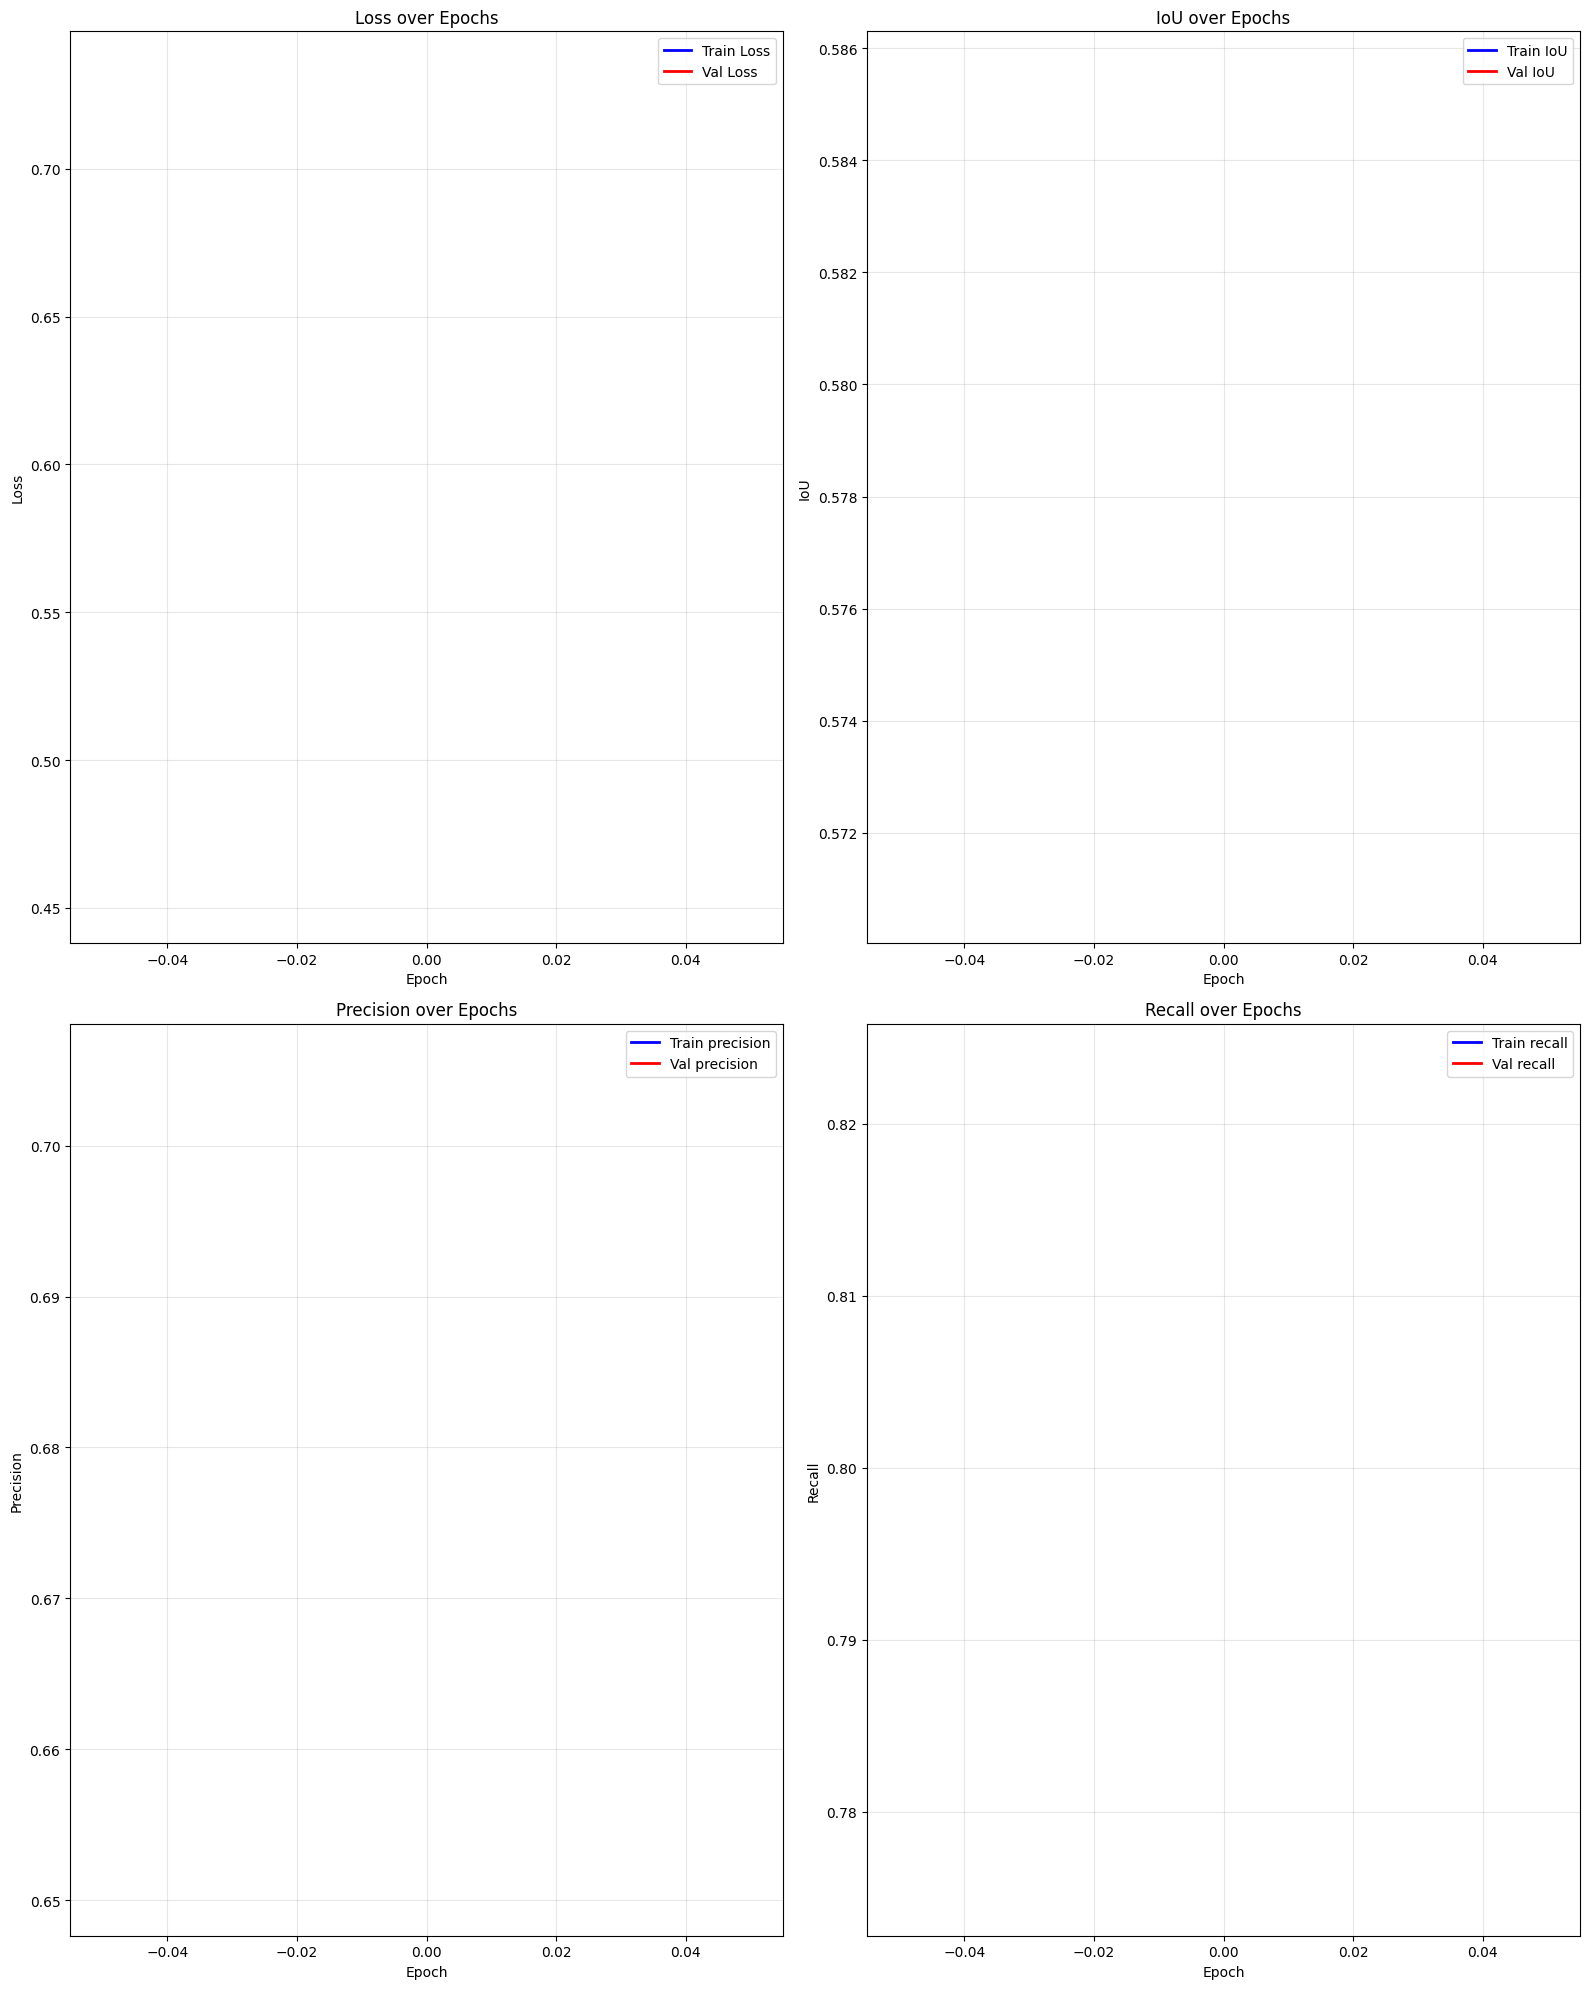

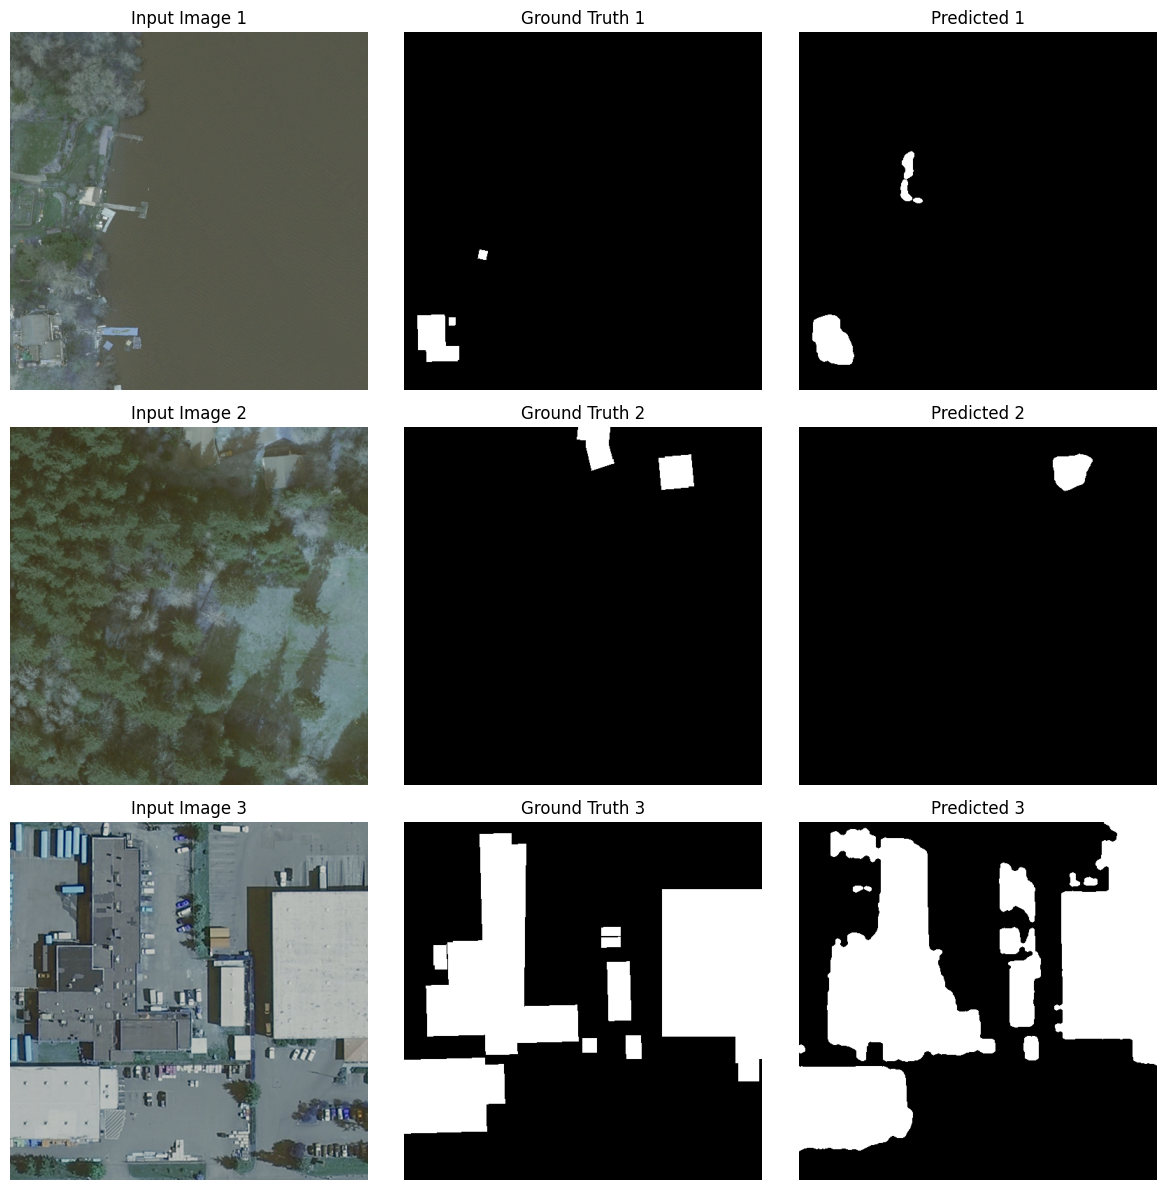

Epoch 1/1
Train Loss: 0.7325, Train IoU: 0.5708, Train precision: 0.6504, Train recall: 0.8234
Val Loss: 0.4521, Val IoU: 0.5856, Val precision: 0.7053, Val recall: 0.7752
Learning Rate: 3.00e-04
Loaded best model with Val IoU: 0.5856


In [26]:
model = smp.Unet(
    encoder_name="efficientnet-b2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
).to(device)

model.decoder.dropout = nn.Dropout2d(0.5)

# for param in model.encoder.parameters():
#     param.requires_grad = True

# Разморозить layer3 и layer4
if hasattr(model.encoder, 'layer3'):
    for param in model.encoder.layer3.parameters():
        param.requires_grad = True
if hasattr(model.encoder, 'layer4'):
    for param in model.encoder.layer4.parameters():
        param.requires_grad = True

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 3e-4},
    {'params': model.decoder.parameters(), 'lr': 1e-4},
    {'params': model.segmentation_head.parameters(), 'lr': 1e-4},
], weight_decay=1e-3)

criterion = CombinedLoss(
    dice_weight=0.8, 
    bce_weight=0.0, 
    focal_weight=1.0,  
    boundary_weight=0.8
)


clear_cuda_memory()
trained_model = train(
    cur_model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    metrics=metrics,
    num_epochs=1,
    patience=10
)

In [ ]:
# Так, одна эпоха здесь показана для сравнения масок в начале и конце обучения. 
# Метрики на модели с предобученными весами, особенно для валидации меняются мало, растут
# довольно нестабильно, если так можно сказать. Однако маски постепенно становятся четче. 
# Даже с учетом постобработки маски на первой эпохе всегда довольно размытые, однако к
# концу обучения границы зданий становятся довольно четкими

In [19]:
def inference(model, test_loader, metric):
    model.eval()
    total_correct = 0
    total_pixels = 0
    
    metric.reset()

    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        # batch_size = inputs.size(0)
        with torch.no_grad():
            outputs = model(inputs)
            # total_samples += batch_size

            preds = (torch.sigmoid(outputs) > 0.5)
            correct = (preds == labels).float()
            total_correct += correct.sum().item()
            total_pixels += correct.numel()
            metric.update(preds, labels.long())
                
    epoch_metric = metric.compute()
    pixel_accuacy = total_correct/ total_pixels
    
    print(epoch_metric, pixel_accuacy)
    
    return epoch_metric, pixel_accuacy

In [ ]:
# Что касается самого обучения, вероятно, одной UNet модели не достаточно для того, чтобы
# добиться значительного повышения метрик
# Довольно значимый разрыв между метриками для тренировки и валидации, возможно, связан
# с использование изображений различных городов, а так же с тем, что в валидации довольно
# много пустых тайлов. 

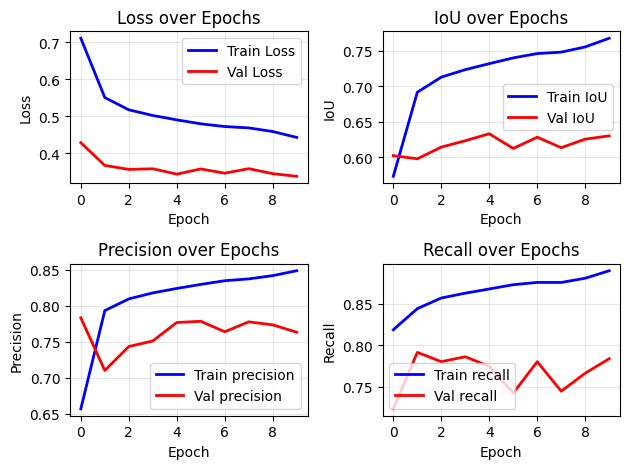

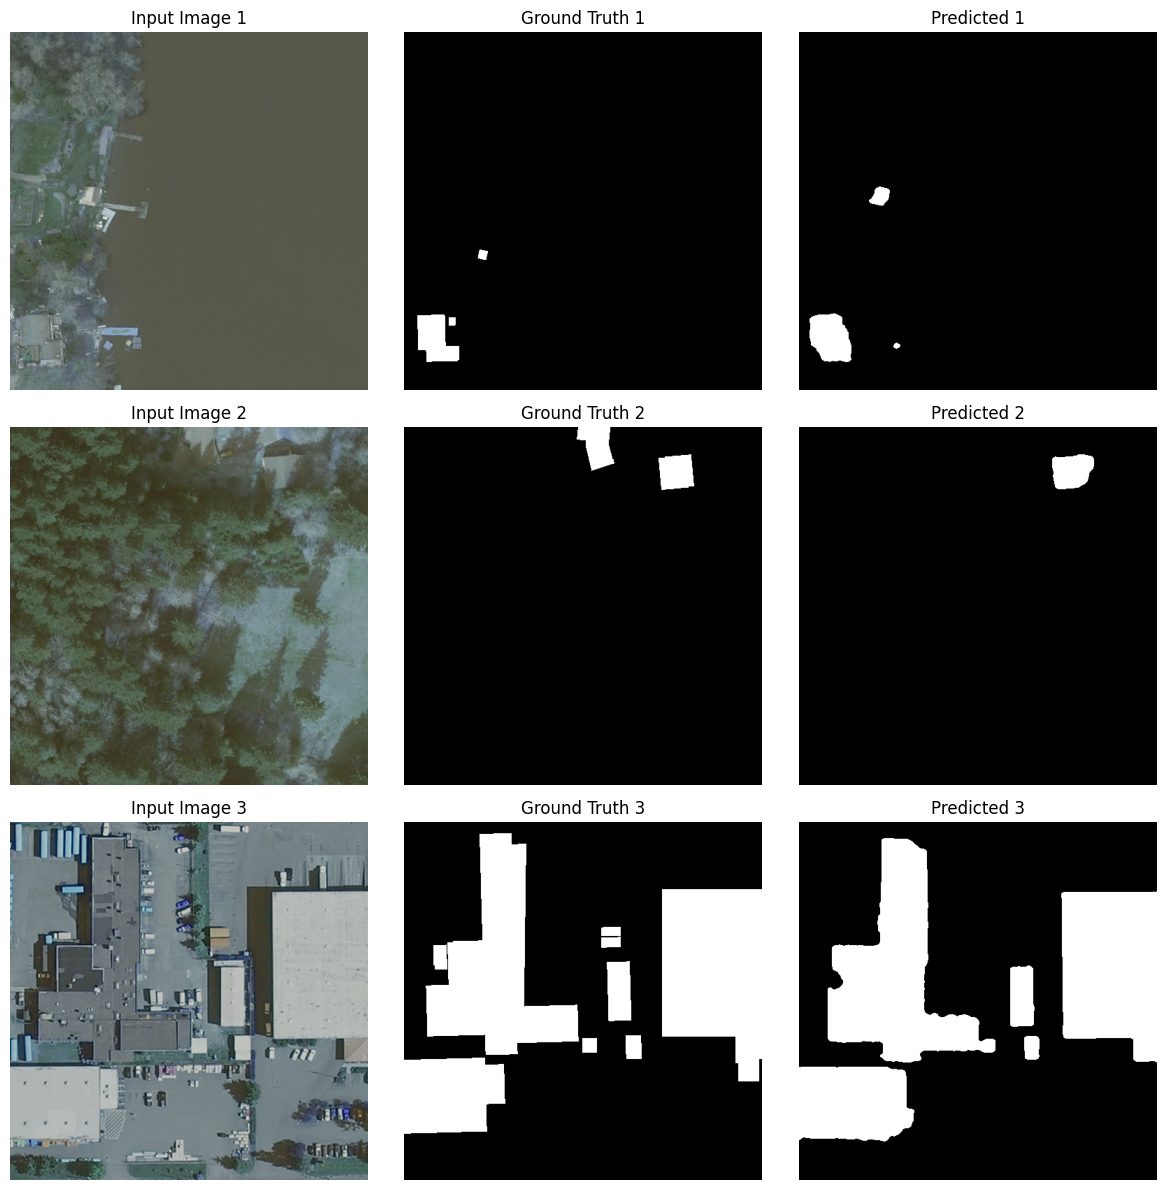

Epoch 10/20
Train Loss: 0.4431, Train IoU: 0.7677, Train precision: 0.8485, Train recall: 0.8897
Val Loss: 0.3379, Val IoU: 0.6304, Val precision: 0.7632, Val recall: 0.7836
Learning Rate: 3.00e-05
Training stopped early at epoch 11
Loaded best model with Val IoU: 0.6334


In [22]:
model1 = smp.Unet(
    encoder_name="efficientnet-b2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
).to(device)

model1.decoder.dropout = nn.Dropout2d(0.5)

# for param in model.encoder.parameters():
#     param.requires_grad = True

# Разморозить layer3 и layer4
if hasattr(model1.encoder, 'layer3'):
    for param in model1.encoder.layer3.parameters():
        param.requires_grad = True
if hasattr(model1.encoder, 'layer4'):
    for param in model1.encoder.layer4.parameters():
        param.requires_grad = True

optimizer = torch.optim.AdamW([
    {'params': model1.encoder.parameters(), 'lr': 3e-4},
    {'params': model1.decoder.parameters(), 'lr': 1e-4},
    {'params': model1.segmentation_head.parameters(), 'lr': 1e-4},
], weight_decay=1e-3)


criterion = CombinedLoss(
    dice_weight=0.8, 
    bce_weight=0.0, 
    focal_weight=1.0,  
    boundary_weight=0.8
)

clear_cuda_memory()
trained_model_1 = train(
    cur_model=model1,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    metrics=metrics,
    num_epochs=20,
    patience=5
)

In [ ]:
# Проверка на тестовой выборке

In [25]:
model = smp.Unet(
    encoder_name="efficientnet-b2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
).to(device)

inference(model, test_dataloader, metrics[0])

100%|██████████| 450/450 [01:34<00:00,  4.77it/s]

tensor(0.2430, device='cuda:0') 0.24746984905666775


(tensor(0.2430, device='cuda:0'), 0.24746984905666775)

In [24]:
inference(trained_model_1, test_dataloader, metrics[0])

100%|██████████| 450/450 [01:34<00:00,  4.75it/s]

tensor(0.7236, device='cuda:0') 0.9177881060706244


(tensor(0.7236, device='cuda:0'), 0.9177881060706244)

In [ ]:
# Выводы
# В задаче оказалось не все так просто, как кажется
# Преодоление порога 0.63-0.64 - все еще задача для исследования
# Завышение результата на тестовой выборке обусловлено выбором более простого города - 
# Чикаго более разнообразен с точки зрения застройки и имеет меньше пустых тайлов
# Поскольку это тестовый город он же используется, как базовый для продакшена модели, 
# но там есть возможность выбрать и другую местность 
# Возможно, требуются архитектурные улучшения, поскольку простой перебор гиперпараметров и
# коэффициентов комбинированного лосса, да и в целом самих энкодеров для unet принес мало
# пользы. 
# Тем не менее выбранная комбинация лоссов, показывает себя лучше, чем наивное
# использование bce или даже комбинации bce и dice loss
# Так же моментов для улучшения является введение других метрик, поскольку оставленные
# сейчас не отражают в полной мере изменение масок
# Существуют довольно интересные варианты извенения архитектуры unet, например добавление
# внимания - возможно стоит попробовать, как следующий этап. Затем перейти на 
# принципиально другие архитектуры